In [1]:
import earthkit.hydro as ekh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit.plots.quickplot as qplot

np.random.seed(1)

# helper function to create plots
def plot(data, norm=mpl.colors.LogNorm()):
    _, ax = plt.subplots()
    ax.contourf(data, norm=norm)
    ax.invert_yaxis()
    ax.grid(False)
    plt.axis("off")
    plt.show()

# River Network Creation

There are two ways to make a river network, `load_river_network` (preferred) and `create_river_network` (for special use cases). `load_river_network` loads a precomputed optimised version of a river network, whilst `create_river_network` creates a river network from an input file. Unless the river network you wish to use is not provided by `load_river_network`, please use `load_river_network`.

In [2]:
river_network = ekh.load_river_network(domain="efas", river_network_version="5")

River network not found in cache (/etc/ecmwf/ssd/ssd1/tmpdirs/ecm7348.943944.20250305_203719.142/tmp16byd8tz_earthkit_hydro/0.1_21310afd8bdf3d1ca275c0ebaf5e2b07417b01dca0979c3980d02c29c923966f.joblib).
River network loaded, saving to cache (/etc/ecmwf/ssd/ssd1/tmpdirs/ecm7348.943944.20250305_203719.142/tmp16byd8tz_earthkit_hydro/0.1_21310afd8bdf3d1ca275c0ebaf5e2b07417b01dca0979c3980d02c29c923966f.joblib).


# Finding Upstream Metrics

Given a river network, a common task is to compute an upstream sum, average or other metric. In earthkit-hydro, this is easily possible to compute for the entire field via `calculate_upstream_metric`.

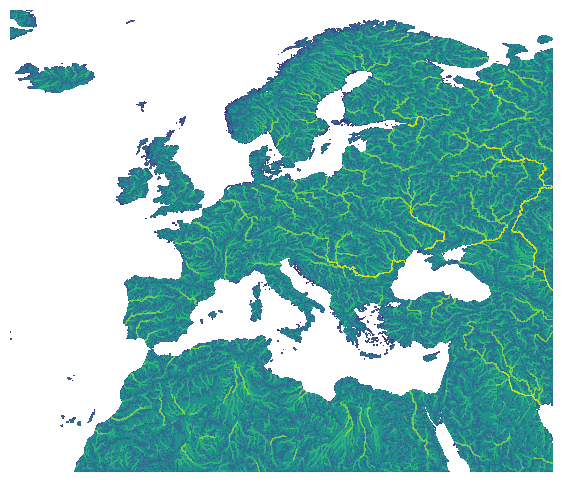

In [3]:
# create or load a field of interest e.g. area, precipitation, discharge
# as an example, we provide a unit field over the domain
unit_field = np.ones(river_network.mask.shape)

upstream_sum_field = ekh.calculate_upstream_metric(river_network, unit_field, metric="sum")

plot(upstream_sum_field)

We can also compute other metrics, such as weighted averages.

In [4]:
random_field = np.random.rand(*river_network.mask.shape)
random_weights = np.random.rand(*river_network.mask.shape)
upstream_sum_field = ekh.calculate_upstream_metric(river_network, random_field, metric="mean", weights=random_weights)

And earthkit-hydro also supports vector fields!

In [5]:
vector_field = np.random.rand(2, 3, *river_network.mask.shape)
upstream_sum_field = ekh.calculate_upstream_metric(river_network, vector_field, metric="max")

# Finding Catchments and Subcatchments

Another common task is finding the catchments or subcatchments defined by a series of points (possibly stations). In earthkit-hydro, this is readily available with `find_catchments` and `find_subcatchments`, respectively.

In [6]:
# create or load the points of interest
points = np.zeros(river_network.mask.shape)

# largest catchment's sink
points[1801, 4529] = 5  # given label 5
# point within largest catchment but not the sink
points[886, 3999] = 2 # given label 2
# separate catchment
points[1621, 3298] = 1 # given label 1

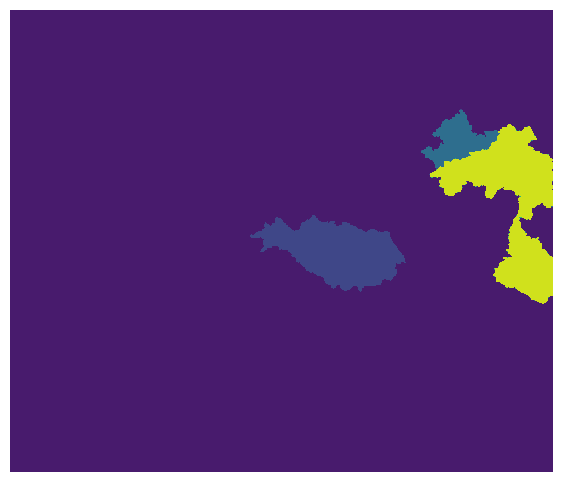

In [7]:
# find and plot the subcatchments
subcatchment_field = ekh.find_subcatchments(river_network, points)

plot(subcatchment_field, norm=None)

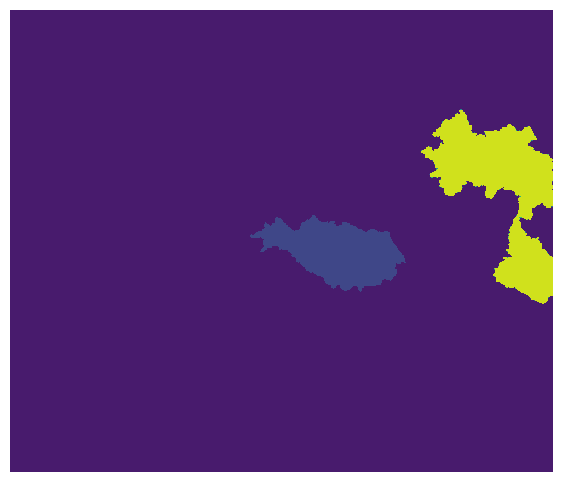

In [8]:
# find and plot the catchments
catchment_field = ekh.find_catchments(river_network, points)

plot(catchment_field, norm=None)

Again, vector fields are supported in earthkit-hydro for all operations.

In [9]:
# create or load the points of interest
points = np.zeros((2, *river_network.mask.shape))

points[0, 1801, 4529] = 5
points[0, 886, 3999] = 2
points[0, 1621, 3298] = 1
points[1, 1801, 4500] = 3
points[1, 886, 3999] = 4

subcatchment_field = ekh.find_subcatchments(river_network, points)

# Computing Metrics Over River Catchments
Finding (sub)catchments is useful, but often one is specifically interested in computing a metric over catchments or subcatchments. Earthkit-hydro provides two functions to do this
- `calculate_catchment_metric`, which computes the metric over the catchment defined by each input point (computes the metric over all upstream points)
- `calculate_subcatchment_metric`, which computes the metric over the subcatchments defined by the input points.

If no points lie in the same catchment, then these two functions are equivalent.

In [10]:
stations = (np.array([1801, 886, 1621]), np.array([4529, 3999, 3298])) # same points as before
random_field = np.random.rand(2, *river_network.mask.shape) # vector field
random_weights = np.random.rand(2, *river_network.mask.shape) # vector field

catchment_metric_at_stations = ekh.calculate_catchment_metric(river_network, random_field, stations, metric="mean")
print(catchment_metric_at_stations)

{(1801, 4529): array([0.50034817, 0.50081842]), (886, 3999): array([0.50009099, 0.50173426]), (1621, 3298): array([0.49966111, 0.49992867])}


In [11]:
subcatchment_metric_at_stations = ekh.calculate_subcatchment_metric(river_network, random_field, stations, metric="mean")
print(subcatchment_metric_at_stations)

{(1801, 4529): array([0.50040836, 0.50060408]), (886, 3999): array([0.50009099, 0.50173426]), (1621, 3298): array([0.49966111, 0.49992867])}


If one wishes to compute a metric over an arbitrary area that isn't a catchment or subcatchment, this is also possible with `calculate_metric_for_labels`.

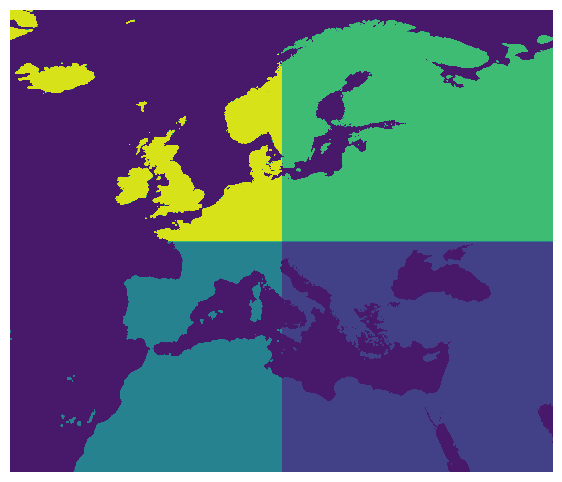

In [12]:
# generate some labelled regions defining where to compute the metric on
labels = np.empty(river_network.mask.shape)
labels[river_network.mask.shape[0]//2:, river_network.mask.shape[1]//2:] = 1
labels[river_network.mask.shape[0]//2:, :river_network.mask.shape[1]//2] = 2
labels[:river_network.mask.shape[0]//2, river_network.mask.shape[1]//2:] = 3
labels[:river_network.mask.shape[0]//2, :river_network.mask.shape[1]//2] = 4
labels_missing_value = 0
labels[~river_network.mask] = labels_missing_value # give anything outside the river network a missing value of 0

plot(labels, norm=None)

In [13]:
random_field = np.random.rand(*river_network.mask.shape)

metric_for_labels = ekh.calculate_metric_for_labels(random_field, labels, metric="mean", labels_mv=labels_missing_value)
print(metric_for_labels)

{1.0: 0.4998714680580828, 2.0: 0.5004262903612107, 3.0: 0.5000347638877423, 4.0: 0.5002925872280425}


And we can return as a field instead of a dictionary if desired.

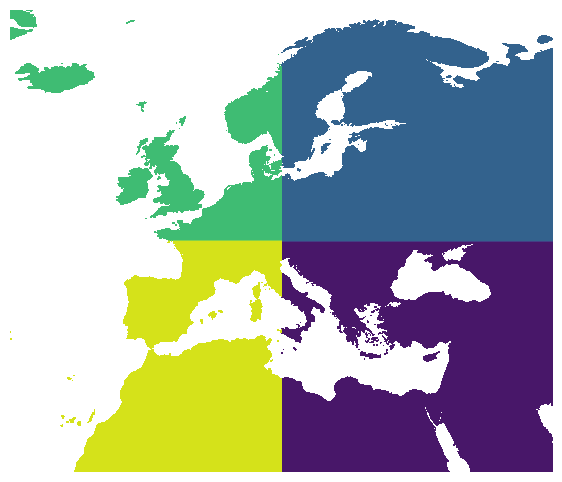

In [14]:
metric_field = ekh.calculate_metric_for_labels(random_field, labels, metric="mean", labels_mv=labels_missing_value, return_field=True)

plot(metric_field, norm=None)

# Subnetwork

Another common function is to compute a subnetwork of the original river network, which is easily possible using the `create_subnetwork` method of the river network.

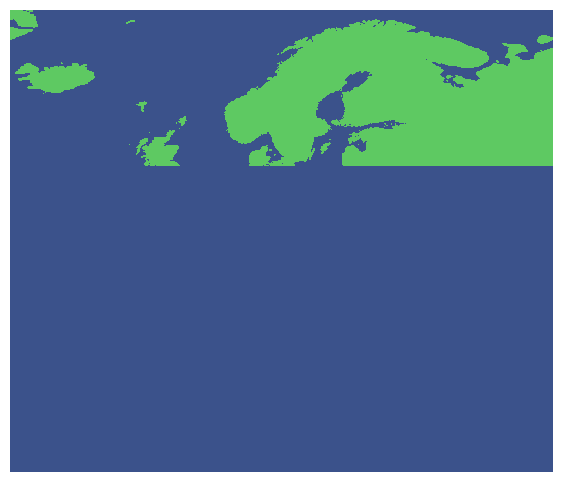

In [15]:
# create a subnetwork given a mask of northern Europe
mask = np.full(river_network.mask.shape, False)
mask[:1000] = True
north_europe_river_network = river_network.create_subnetwork(mask)

plot(north_europe_river_network.mask, norm=None)

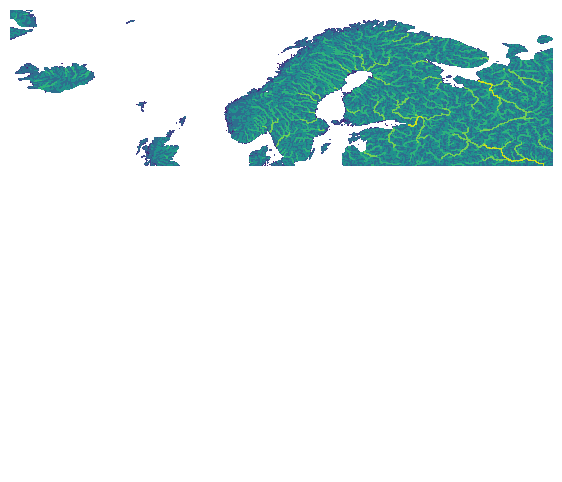

In [16]:
# conduct accuflux on the subnetwork
accuflux_field = ekh.calculate_upstream_metric(north_europe_river_network, unit_field, "sum")
plot(accuflux_field)

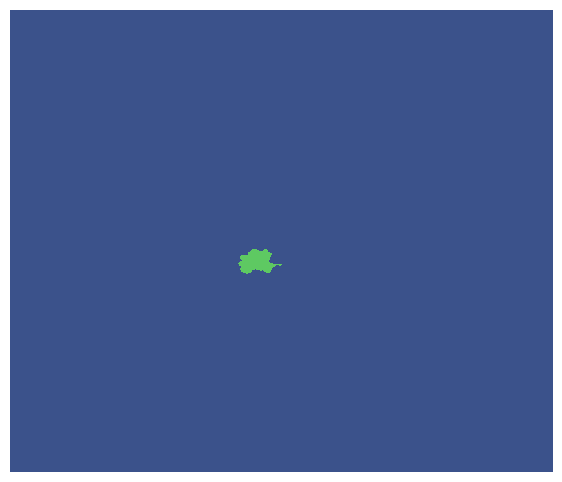

In [17]:
# create a subnetwork of a river catchment
# can find the mask directly by doing catchment with boolean arrays
points = np.full(river_network.mask.shape, False)
points[1636, 2267] = True  # Po river catchment sink
catchment_mask = ekh.find_catchments(river_network, points, mv=False)
po_catchment_network = river_network.create_subnetwork(catchment_mask)
plot(po_catchment_network.mask, norm=None)

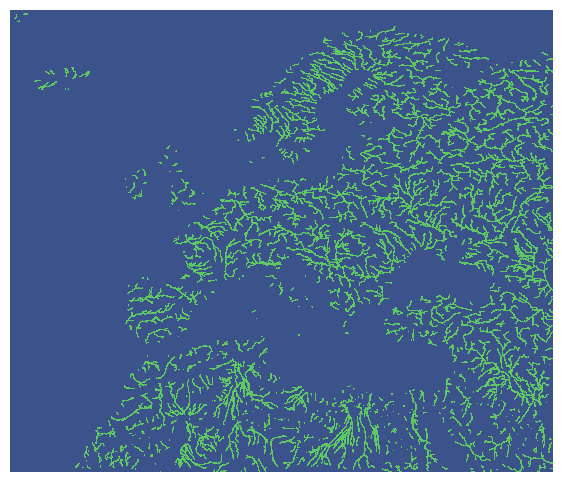

In [18]:
# create a subnetwork of large rivers only
accuflux_field = ekh.calculate_upstream_metric(river_network, unit_field, "sum")
large_rivers = accuflux_field > 1000
large_river_network = river_network.create_subnetwork(large_rivers)
plot(large_river_network.mask, norm=None)

# Upstream & Downstream

It is also possible to move a river network downstream or upstream with the `move_downstream` and `move_upstream` methods, respectively.

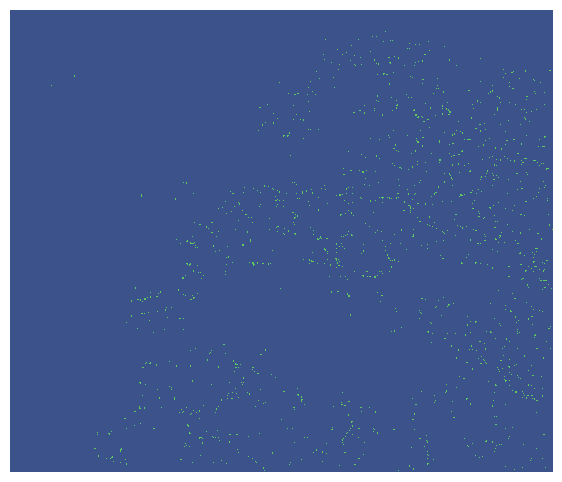

In [19]:
# find confluences of the large rivers
upstream_field = ekh.move_downstream(large_river_network, unit_field)
plot(upstream_field > 1, norm=None)

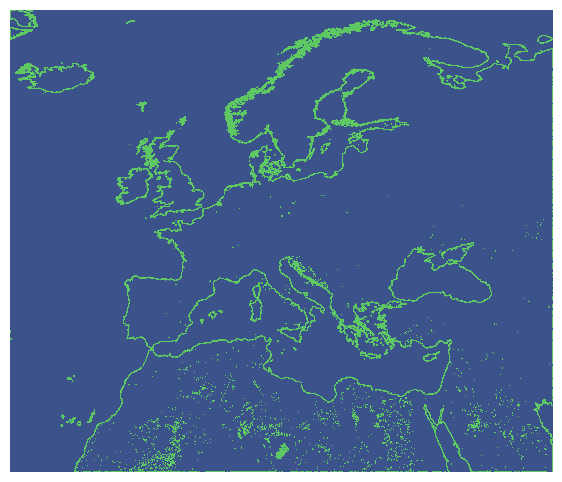

In [20]:
# find sinks of the original river network
downstream_field = ekh.move_upstream(river_network, unit_field)
plot(downstream_field == 0, norm=None)

And of course these support vector fields also.

In [21]:
random_field = np.random.rand(3,4,*river_network.mask.shape)
downstream_field = ekh.move_upstream(river_network, random_field)

# Example with Earthkit and Precipitation Maps

Finally, earthkit-hydro is part of the earthkit ecosystem and interplays with other earthkit packages.

In [22]:
style = ekp.styles.Style(
    colors="Blues",
    levels=[0, 0.5, 1, 2, 5, 10, 50, 100, 500, 1000, 2000, 3000, 4000],
    extend="max",
)

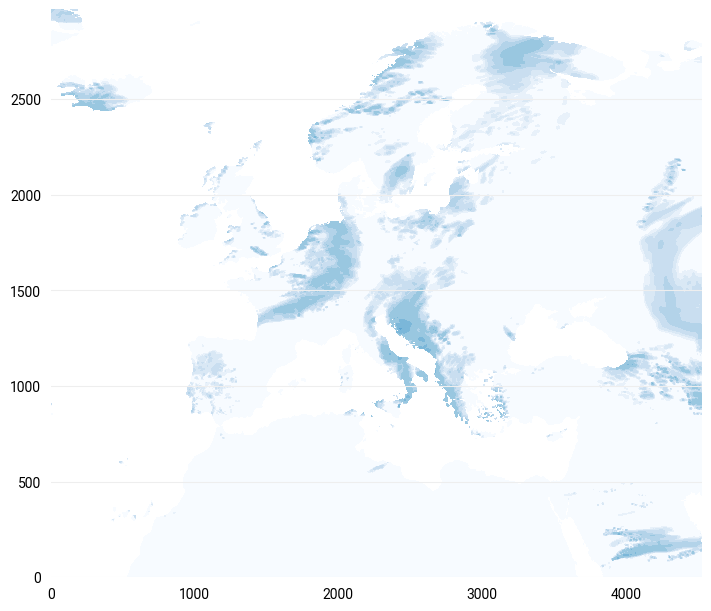

In [23]:
precipitation_field = ekd.from_source(
    "file",
    "/ec/ws4/tc/emos/work/cems/floods/efas/emos/efas/europe5km/202502/EUD2025022700/forcings/R06a.nc",
)[0].to_numpy()

qplot.contourf(precipitation_field[::-1, :], style=style)

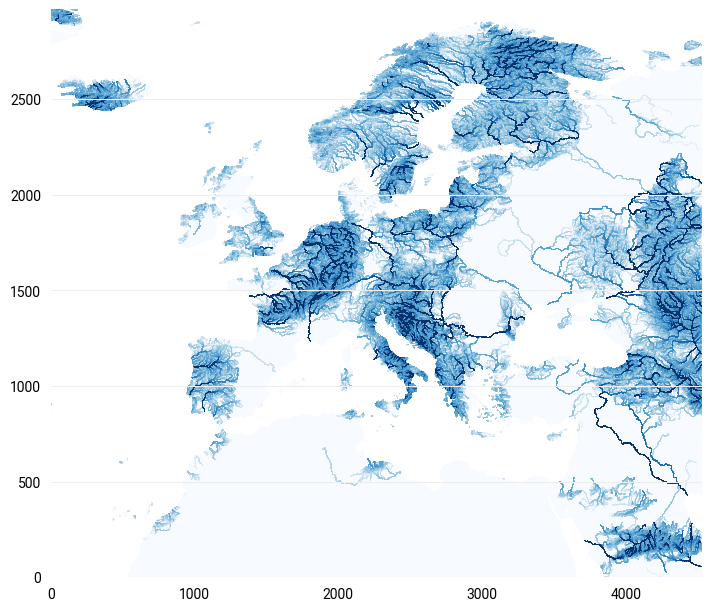

In [24]:
accuflux_field = ekh.flow_downstream(river_network, precipitation_field)
qplot.contourf(accuflux_field[::-1, :], style=style)